In [1]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [2]:
import numpy as np
import time
from copy import deepcopy
from pprint import pprint
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.colors as colors
from hydra import initialize, compose
from glob import glob
import pickle

from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import build_default_calc, build_default_source
from lenstronomy.Util import data_util
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman

from package.helpers import pandeia_input, pyhalo
from package.lenses.sample_skypy_lens import SampleSkyPyLens
from package.plots import diagnostic_plot, plot, plot_util, overplot
from package.utils import util
from package.analysis import stats

plt.style.use(f'{repo_path}/package/mplstyle/science.mplstyle')

In [3]:
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.pickle_dir, config.machine.repo_dir

figure_dir = os.path.join(repo_dir, 'figures')
pickle_dir = os.path.join(pickle_dir, 'pyhalo')
array_dir = os.path.join(array_dir, 'pandeia_noise_residuals')
util.create_directory_if_not_exists(array_dir)

In [4]:
csv = os.path.join(repo_path, 'data', 'roman_spacecraft_and_instrument_parameters.csv')

In [13]:
num_samples = 10000

lens = SampleSkyPyLens()
# add CDM subhalos; NB same subhalo population for all
with open(os.path.join(pickle_dir, 'cdm_subhalos_for_sample_skypy_lens'), 'rb') as results_file:
    realizationCDM = pickle.load(results_file)
lens.add_subhalos(*pyhalo.realization_to_lensing_quantities(realizationCDM))
model = lens.get_array(num_pix=51 * 5, side=5.61)

In [14]:
calc, _ = pandeia_input.build_pandeia_calc(csv=csv, 
                                        array=model, 
                                        lens=lens, 
                                        band='f106', 
                                        num_samples=num_samples)

100%|██████████| 5908/5908 [00:41<00:00, 142.90it/s]

Point source conversion complete: placed 5908 point sources
Estimated calculation time: 0:07:44


In [15]:
all_on, _ = pandeia_input.get_pandeia_image(calc)

Performing Pandeia calculation...
Pandeia calculation complete in 0:09:18


In [36]:
np.save(os.path.join(array_dir, 'all_on'), all_on)

In [5]:
all_on = np.load(os.path.join(array_dir, 'all_on.npy'))

# Turn off cosmic ray noise

In [16]:
crs_off_calc = deepcopy(calc)

calculation_dict = pandeia_input.get_calculation_dict(init=True)
crs_off_dict = deepcopy(calculation_dict)

crs_off_dict['noise']['crs'] = False
pprint(crs_off_dict)

crs_off_calc['calculation'] = crs_off_dict

crs_off, execution_time = pandeia_input.get_pandeia_image(crs_off_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(array_dir, 'crs_off.npy'), crs_off)

{'effects': {'saturation': True},
 'noise': {'crs': False,
           'dark': True,
           'excess': False,
           'ffnoise': True,
           'readnoise': True,
           'scatter': True}}
Performing Pandeia calculation...
Pandeia calculation complete in 0:09:16
Execution time: 0:09:16


# Turn off detector dark current noise

In [20]:
dark_off_calc = deepcopy(calc)

calculation_dict = pandeia_input.get_calculation_dict(init=True)
dark_off_dict = deepcopy(calculation_dict)

dark_off_dict['noise']['dark'] = False
pprint(dark_off_dict)

dark_off_calc['calculation'] = dark_off_dict

dark_off, execution_time = pandeia_input.get_pandeia_image(dark_off_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(array_dir, 'dark_off.npy'), dark_off)

{'effects': {'saturation': True},
 'noise': {'crs': True,
           'dark': False,
           'excess': False,
           'ffnoise': True,
           'readnoise': True,
           'scatter': True}}
Performing Pandeia calculation...
Pandeia calculation complete in 0:09:14
Execution time: 0:09:14


# Turn off flat-field noise

In [21]:
ffnoise_off_calc = deepcopy(calc)

calculation_dict = pandeia_input.get_calculation_dict(init=True)
ffnoise_off_dict = deepcopy(calculation_dict)

ffnoise_off_dict['noise']['ffnoise'] = False
pprint(ffnoise_off_dict)

ffnoise_off_calc['calculation'] = ffnoise_off_dict

ffnoise_off, execution_time = pandeia_input.get_pandeia_image(ffnoise_off_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(array_dir, 'ffnoise_off.npy'), ffnoise_off)

{'effects': {'saturation': True},
 'noise': {'crs': True,
           'dark': True,
           'excess': False,
           'ffnoise': False,
           'readnoise': True,
           'scatter': True}}
Performing Pandeia calculation...
Pandeia calculation complete in 0:09:14
Execution time: 0:09:14


# Turn off detector read noise

In [22]:
readnoise_off_calc = deepcopy(calc)

calculation_dict = pandeia_input.get_calculation_dict(init=True)
readnoise_off_dict = deepcopy(calculation_dict)

readnoise_off_dict['noise']['readnoise'] = False
pprint(readnoise_off_dict)

readnoise_off_calc['calculation'] = readnoise_off_dict

readnoise_off, execution_time = pandeia_input.get_pandeia_image(readnoise_off_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(array_dir, 'readnoise_off.npy'), readnoise_off)

{'effects': {'saturation': True},
 'noise': {'crs': True,
           'dark': True,
           'excess': False,
           'ffnoise': True,
           'readnoise': False,
           'scatter': True}}
Performing Pandeia calculation...
Pandeia calculation complete in 0:09:13
Execution time: 0:09:13


# Turn off Echelle scattering noise

In [23]:
scatter_off_calc = deepcopy(calc)

calculation_dict = pandeia_input.get_calculation_dict(init=True)
scatter_off_dict = deepcopy(calculation_dict)

scatter_off_dict['noise']['scatter'] = False
pprint(scatter_off_dict)

scatter_off_calc['calculation'] = scatter_off_dict

scatter_off, execution_time = pandeia_input.get_pandeia_image(scatter_off_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(array_dir, 'scatter_off.npy'), scatter_off)

{'effects': {'saturation': True},
 'noise': {'crs': True,
           'dark': True,
           'excess': False,
           'ffnoise': True,
           'readnoise': True,
           'scatter': False}}
Performing Pandeia calculation...
Pandeia calculation complete in 0:09:03
Execution time: 0:09:03


# Turn off pixel saturation effects

In [24]:
saturation_off_calc = deepcopy(calc)

calculation_dict = pandeia_input.get_calculation_dict(init=True)
saturation_off_dict = deepcopy(calculation_dict)

saturation_off_dict['effects']['saturation'] = False
pprint(saturation_off_dict)

saturation_off_calc['calculation'] = saturation_off_dict

saturation_off, execution_time = pandeia_input.get_pandeia_image(saturation_off_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(array_dir, 'saturation_off.npy'), saturation_off)

{'effects': {'saturation': False},
 'noise': {'crs': True,
           'dark': True,
           'excess': False,
           'ffnoise': True,
           'readnoise': True,
           'scatter': True}}
Performing Pandeia calculation...
Pandeia calculation complete in 0:09:10
Execution time: 0:09:10


# Plot residuals

In [6]:
crs_off = np.load(os.path.join(array_dir, 'crs_off.npy'))
dark_off = np.load(os.path.join(array_dir, 'dark_off.npy'))
ffnoise_off = np.load(os.path.join(array_dir, 'ffnoise_off.npy'))
readnoise_off = np.load(os.path.join(array_dir, 'readnoise_off.npy'))
scatter_off = np.load(os.path.join(array_dir, 'scatter_off.npy'))
saturation_off = np.load(os.path.join(array_dir, 'saturation_off.npy'))

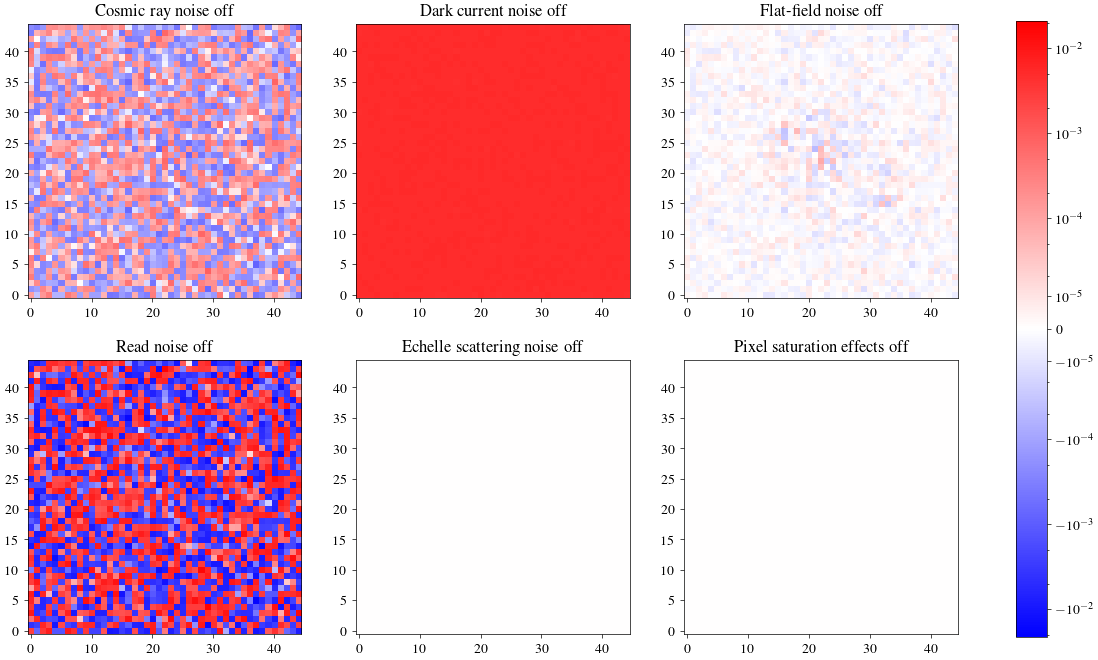

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

array_list = [all_on - crs_off, all_on - dark_off, all_on - ffnoise_off, all_on - readnoise_off, all_on - scatter_off, all_on - saturation_off]

norm = plot_util.get_norm(array_list, linear_width=0.00001)

ax0 = ax[0,0].imshow(all_on - crs_off, cmap='bwr', norm=norm)
ax[0,0].set_title('Cosmic ray noise off')

ax1 = ax[0,1].imshow(all_on - dark_off, cmap='bwr', norm=norm)
ax[0,1].set_title('Dark current noise off')

ax2 = ax[0,2].imshow(all_on - ffnoise_off, cmap='bwr', norm=norm)
ax[0,2].set_title('Flat-field noise off')

ax3 = ax[1,0].imshow(all_on - readnoise_off, cmap='bwr', norm=norm)
ax[1,0].set_title('Read noise off')

ax4 = ax[1,1].imshow(all_on - scatter_off, cmap='bwr', norm=norm)
ax[1,1].set_title('Echelle scattering noise off')

ax5 = ax[1,2].imshow(all_on - saturation_off, cmap='bwr', norm=norm)
ax[1,2].set_title('Pixel saturation effects off')

fig.colorbar(ax0, ax=[ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2]])

plt.savefig(os.path.join(figure_dir, 'noise_asinh.png'))
plt.show()

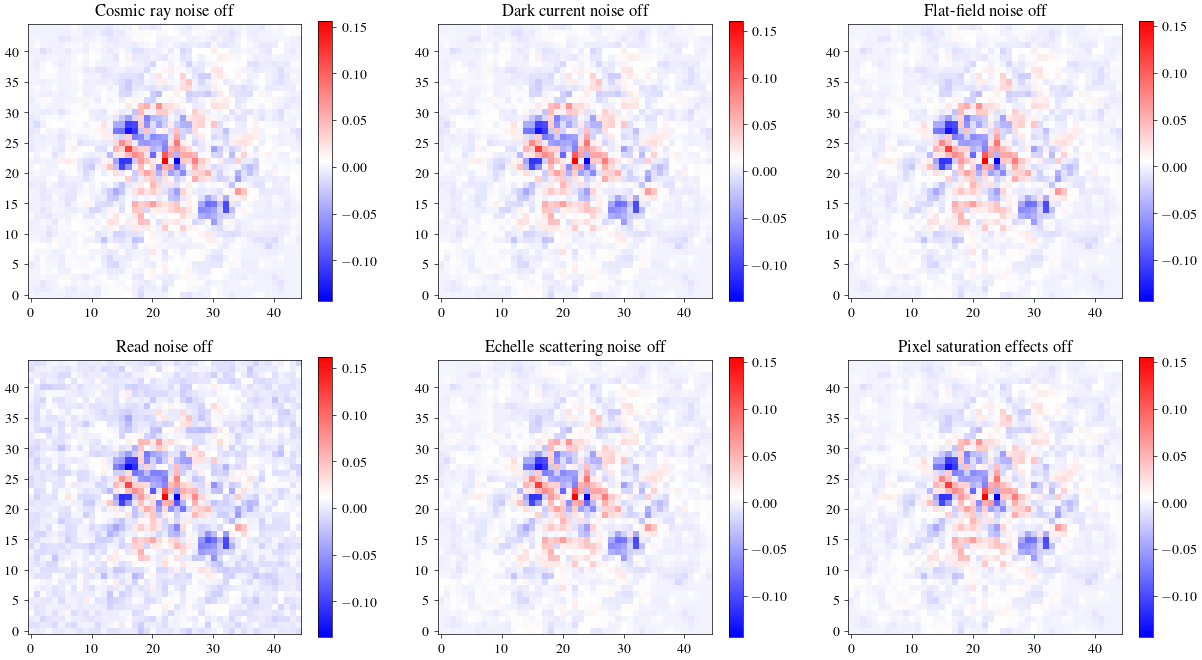

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

array_list = [pandeia - crs_off, pandeia - dark_off, pandeia - ffnoise_off, pandeia - readnoise_off, pandeia - scatter_off, pandeia - saturation_off]

ax0 = ax[0,0].imshow(pandeia - crs_off, cmap='bwr')
ax[0,0].set_title('Cosmic ray noise off')

ax1 = ax[0,1].imshow(pandeia - dark_off, cmap='bwr')
ax[0,1].set_title('Dark current noise off')

ax2 = ax[0,2].imshow(pandeia - ffnoise_off, cmap='bwr')
ax[0,2].set_title('Flat-field noise off')

ax3 = ax[1,0].imshow(pandeia - readnoise_off, cmap='bwr')
ax[1,0].set_title('Read noise off')

ax4 = ax[1,1].imshow(pandeia - scatter_off, cmap='bwr')
ax[1,1].set_title('Echelle scattering noise off')

ax5 = ax[1,2].imshow(pandeia - saturation_off, cmap='bwr')
ax[1,2].set_title('Pixel saturation effects off')

plt.colorbar(ax0, ax=ax[0,0])
plt.colorbar(ax1, ax=ax[0,1])
plt.colorbar(ax2, ax=ax[0,2])
plt.colorbar(ax3, ax=ax[1,0])
plt.colorbar(ax4, ax=ax[1,1])
plt.colorbar(ax5, ax=ax[1,2])

plt.savefig(os.path.join(figure_dir, 'noise_own_colorbars.png'))
plt.show()

In [39]:
print(np.count_nonzero(all_on - scatter_off))
print(np.count_nonzero(all_on - saturation_off))

0
0


In [29]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

In [30]:
def get_limit(array):
    abs_min, abs_max = abs(np.min(array)), abs(np.max(array))
    return np.max([abs_min, abs_max])

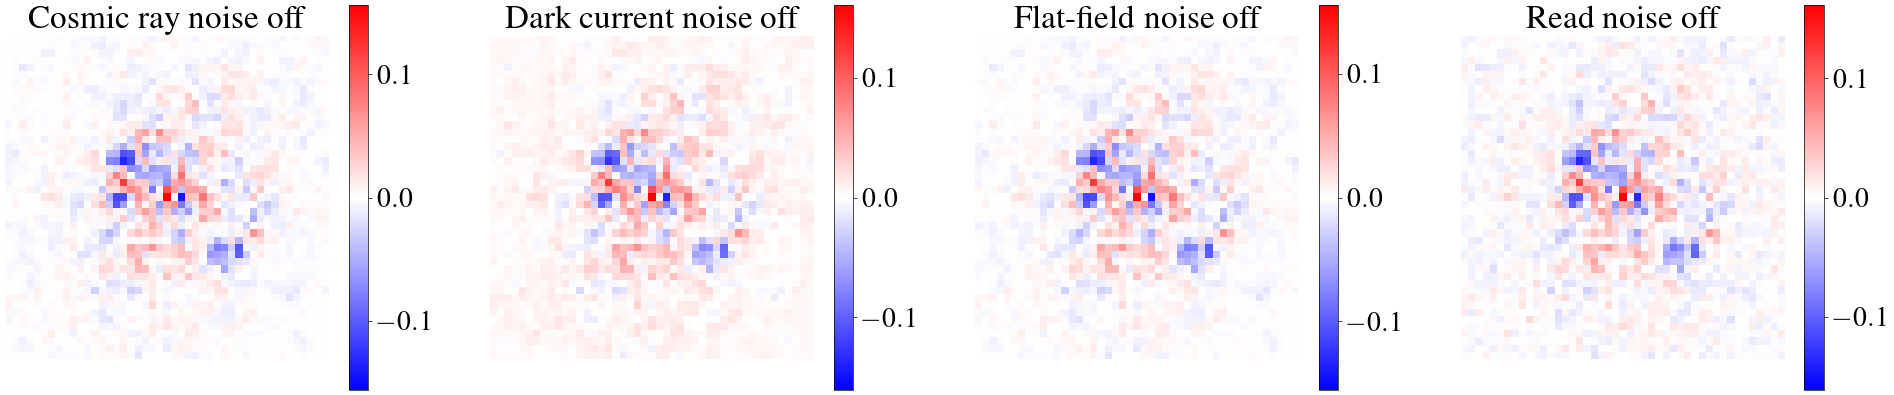

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24, 5))

array_list = [pandeia - crs_off, pandeia - dark_off, pandeia - ffnoise_off, pandeia - readnoise_off]

ax0 = ax[0].imshow(pandeia - crs_off, cmap='bwr', vmin=-get_limit(pandeia - crs_off), vmax=get_limit(pandeia - crs_off))
ax[0].set_title('Cosmic ray noise off')

ax1 = ax[1].imshow(pandeia - dark_off, cmap='bwr', vmin=-get_limit(pandeia - dark_off), vmax=get_limit(pandeia - dark_off))
ax[1].set_title('Dark current noise off')

ax2 = ax[2].imshow(pandeia - ffnoise_off, cmap='bwr', vmin=-get_limit(pandeia - ffnoise_off), vmax=get_limit(pandeia - ffnoise_off))
ax[2].set_title('Flat-field noise off')

ax3 = ax[3].imshow(pandeia - readnoise_off, cmap='bwr', vmin=-get_limit(pandeia - readnoise_off), vmax=get_limit(pandeia - readnoise_off))
ax[3].set_title('Read noise off')

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
ax[3].set_axis_off()

plt.colorbar(ax0, ax=ax[0])
plt.colorbar(ax1, ax=ax[1])
plt.colorbar(ax2, ax=ax[2])
plt.colorbar(ax3, ax=ax[3])

plt.savefig(os.path.join(figure_dir, 'noise_own_colorbars.png'))
plt.show()

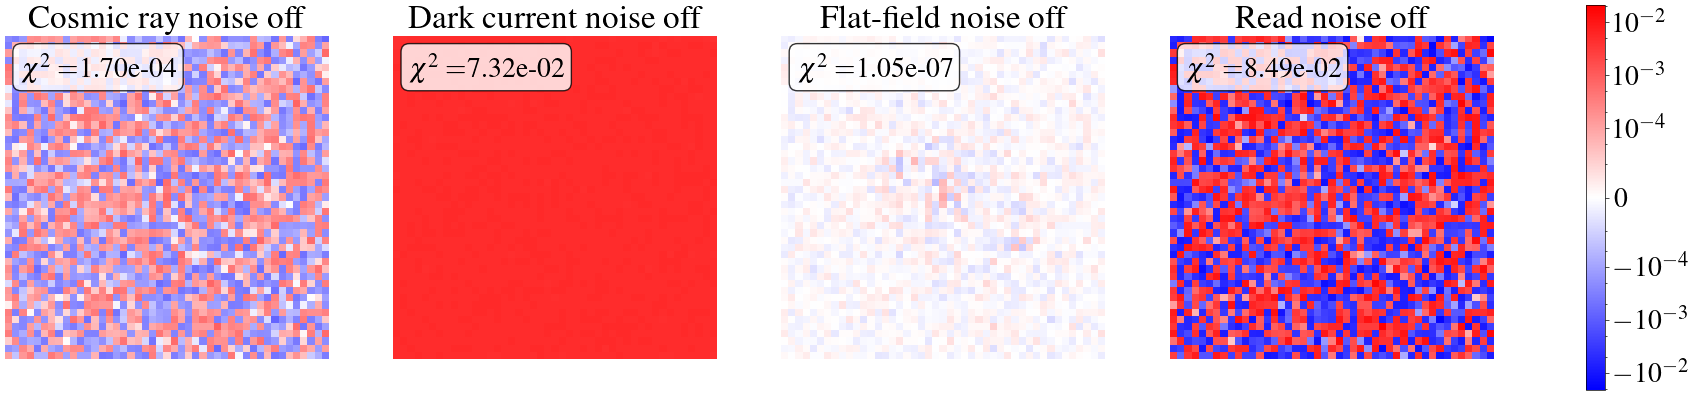

In [8]:
fontsize = 20
matplotlib.rcParams.update({'font.size': fontsize})

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24, 5))

array_list = [all_on - crs_off, all_on - dark_off, all_on - ffnoise_off, all_on - readnoise_off]
title_list = ['Cosmic ray noise off', 'Dark current noise off', 'Flat-field noise off', 'Read noise off']

norm = plot_util.get_norm(array_list, linear_width=0.00001)

for i, array in enumerate(array_list):
    axis = ax[i].imshow(array, cmap='bwr', norm=norm)
    ax[i].set_title(title_list[i])
    ax[i].set_axis_off()

fig.colorbar(axis, ax=ax, ticks=[-0.1, -0.01, -0.001, -0.0001, 0, 0.0001, 0.001, 0.01, 0.1])

chi_square_list = []
chi_square_list.append(stats.chi_square(crs_off, all_on))
chi_square_list.append(stats.chi_square(dark_off, all_on))
chi_square_list.append(stats.chi_square(ffnoise_off, all_on))
chi_square_list.append(stats.chi_square(readnoise_off, all_on))
chi_square_list = ['$\chi^2 = $' + util.scientific_notation_string(i) for i in chi_square_list]

# create text boxes
overplot.text_boxes(ax, chi_square_list, fontsize=fontsize, alpha=0.8)

plt.savefig(os.path.join(figure_dir, 'noise_asinh.png'))
plt.show()